In [68]:
import os
import sys
sys.path.append('..') 
import yaml
import pandas as pd
import numpy as np
import pickle
from src.utils.utils_p import YamlParser,Upload_Download_Pickle,Config_Paths,Feature_Selection_Configs,Model_Configs,Create_Labels_Configs
from src.data.CollectData.CollectDataFromCSV import *
from src.preprocessing.Data_Preprocessing import *
from src.combineDatasets.Combine_Datasets import *
from src.featureProcessing.SplitDataset.Split_Train_Test import *
from src.featureProcessing.SplitDataset.Vertical_Split import *
from src.featureProcessing.Feature_Selection.Basic_Elemination import *
from src.featureProcessing.Feature_Selection.Wrapper import *
from src.featureProcessing.Feature_Selection.Hybrid import *
from src.featureProcessing.Feature_Selection.Unigini import *
from src.featureProcessing.Feature_Selection.Correlation import *
from src.featureProcessing.Feature_Extraction.Normalize import *
from src.featureProcessing.Feature_Extraction.Rolling import *
from src.featureProcessing.Imputation.Basic_Imputation import *
#from src.processing.Model import *
from src.model.Classification.Random_Forest_Tuning import *
from src.model.Classification.XGBoost_Tuning import *
from src.model.Classification.LightGBM_Tuning import *
from src.model.Classification.CatBoost_Tuning import *
from src.model.Classification.SVC_Tuning import *
from src.model.Classification.Voting import *
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [69]:
path=Config_Paths().get_processed_path()
cpath=Config_Paths().get_combineddatasets_path()
rpath=Config_Paths().get_raw_path()
prepath=Config_Paths().get_intermediate_path()
modelpath=Config_Paths().get_model_path()

In [70]:
combined_data=pd.read_csv('smartwind_20_21.csv',delimiter='|',header=0)

D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (137,138,139) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
from datetime import datetime, timedelta
# Değişkenleri rename ettim:
renamecolumns= {'timestamp':'Period',
'event_id':'event_id',
'fault':'Events_binary',                
'lost_production_kwh':'lost_production_kwh' }
#combined_data.head()
logs = combined_data.rename(columns=renamecolumns)
lab_col=['Period','wtg_id','Events_binary','event_id','category','description','lost_production_kwh']
Labels_df=logs[lab_col]
Labels_df.columns=['Period','wtg_id','Events_binary','event_id','category','description','lost_production_kwh']
Features_df=logs.drop(['wtg_id','event_id','category','description','lost_production_kwh'],axis=1)
for i in logs.wtg_id.unique():
    print(i)
    df_turbine=logs[(logs.wtg_id==i)& (logs.Period.astype('datetime64[ns]')<='2021-01-01 00:00:00')]
    lab_turbine=Labels_df[(Labels_df.wtg_id==i)& (Labels_df.Period.astype('datetime64[ns]')<='2021-01-01 00:00:00')]
    df_turbine=df_turbine.drop(['wtg_id','event_id','category','description','lost_production_kwh'],axis=1)
    lab_turbine['onedayPeriod']=lab_turbine['Period'].astype('datetime64[ns]')- timedelta(days=2)
    lab_turbine=lab_turbine.set_index('Period')
    tag=lab_turbine[lab_turbine['Events_binary']==1]
    for x in tag.index:
        #print(x)
        #print(tag.loc[i,'onedayPeriod'])
        lab_turbine['Events_binary']=np.where((lab_turbine.index<=x)&( pd.to_datetime(lab_turbine.index)>tag.loc[x,'onedayPeriod']),1,lab_turbine['Events_binary'])
    lab_turbine.reset_index(inplace=True)
    Upload_Download_Pickle().save_dataset_pickle(prepath,  'Features'+str(i), df_turbine)
    Upload_Download_Pickle().save_dataset_pickle(prepath,  'Labels'+str(i), lab_turbine)   

T02


D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


T04
T08
T09
T10
T11
T12
T22
T27
T45
T47
T48
T49
T50
T51
T52
T53
T54
T06


In [72]:
del combined_data,Labels_df,Features_df

In [73]:
#Combine Multiple Identical Datasets
Combine_Datasets().multi_combine_dataset()

Number of  Events_binary  Events : 10337 on  T02
Number of  Events_binary  Events : 15846 on  T04
Number of  Events_binary  Events : 25962 on  T08
Number of  Events_binary  Events : 12120 on  T09
Number of  Events_binary  Events : 21155 on  T10
['Features', 'Labels', 'AllLabels']
Number of  Events_binary  Events : 10337 on  T02
Number of  Events_binary  Events : 15846 on  T04
Number of  Events_binary  Events : 25962 on  T08
Number of  Events_binary  Events : 12120 on  T09
Number of  Events_binary  Events : 21155 on  T10


In [74]:
#Sonrasında Imputation uygula bir verilen değerler için bir de np.nan değerler için:
Basic_Imputation().impute_before_split()

Features_df_new=Upload_Download_Pickle().download_pickle(cpath, 'Features_df_new')
Features_List_new=Upload_Download_Pickle().download_pickle(cpath, 'Features_List_new')
#Fillna values with -999999
Features_df_new=Features_df_new.fillna(-999999)
Features_list_new_v1=[]
for data in Features_List_new:    
    data=data.fillna(-999999)
    Features_list_new_v1.append(data)
    
Upload_Download_Pickle().save_dataset_pickle(cpath,'Features_df_new',Features_df_new)
Upload_Download_Pickle().save_dataset_pickle(cpath,'Features_List_new',Features_list_new_v1)

#v2 oluşturuyoruz ama henüz kullanmıyoruz.
Default_values=[-999999,-888888]
Features_df_new_v2=Features_df_new.replace(Default_values, np.nan)
Features_list_new_v2=[]
for data in Features_list_new_v1:    
    data=data.replace(Default_values, np.nan)
    Features_list_new_v2.append(data)
#v2 nan olarak kaydediyoruz:  
Upload_Download_Pickle().save_dataset_pickle(cpath,'Features_df_nan',Features_df_new_v2)
Upload_Download_Pickle().save_dataset_pickle(cpath,'Features_List_nan',Features_list_new_v2)
#Split Train Test (Horizontal ayır)
Split_Train_Test().split_train_testset()
#Burda anomaly ve nan değerleri için exstra imputation yapılabilir.
#tum default değerleri nan ile değiştir. meta data muhabbetine bak!
#X_test=Upload_Download_Pickle().download_pickle(path, 'X_test')
#y_test=Upload_Download_Pickle().download_pickle(path, 'y_test')
#X_trains=Upload_Download_Pickle().download_pickle(path, 'X_trains')
#y_trains=Upload_Download_Pickle().download_pickle(path, 'y_trains')
#default değerler nan ile değiştirme kodu?

fill_data
['Features_df', 'Features_List']
                Period  blade_2_actual_value_a_  blade_3_actual_value_a_  \
0  2020-01-01 00:10:00                46.595005                46.694767   
1  2020-01-01 00:20:00                 0.358820                 0.929569   
2  2020-01-01 00:30:00                 0.358796                 0.929877   
3  2020-01-01 00:40:00                 0.358797                 0.930119   
4  2020-01-01 00:50:00                 0.358799                 0.930321   

   blade_1_set_value_  blade_2_set_value_  blade_1_actual_value_a_  \
0           46.802193           46.568718                46.828564   
1            1.721363            0.356799                 1.729248   
2            1.721363            0.356799                 1.729322   
3            1.721363            0.356799                 1.729396   
4            1.721363            0.356799                 1.729475   

   blade_1_actual_value_b_  blade_2_actual_value_b_  blade_3_actual_value_b_  \

KeyError: 'Power_kW'

In [ ]:
Basic_Elemination().featureSelection() 
#Feature Extraction: Normalize Smooth diff etc.
#Sonrasında Feature Selection bunu yaparken nan değerleri default değerlerle dolu halini kullan.
#Fault Detection Çalıştır. bunu yaparken de mümkünse proba kullan prob sonuçlarının yerine!! zor iş brace yourself 
# 1 gün öncesine kadar tagle öyle bakalım.

In [ ]:
meta=Upload_Download_Pickle().download_pickle(path, 'meta')

In [ ]:
meta.groupby('STATUS').count()

In [ ]:
meta[meta['STATUS']!='KEEP']

In [ ]:
meta=Upload_Download_Pickle().download_pickle(path, 'meta')

In [ ]:
meta.groupby('STATUS').count()

In [ ]:
unigini=Upload_Download_Pickle().download_pickle(path, 'unigini')

In [ ]:
unigini

In [3]:
Correlation().featureSelection() 

metadata already created.
False
X_trains (197640, 138)
y_trains (197640,)
X_train (158112, 138)
X_valid (39528, 138)
feature_num ['Blade2_act_val_A_degree', 'Blade3_act_val_A_degree', 'Blade1_set_val_degree', 'Blade1_act_val_A_degree', 'Blade1_act_val_B_degree', 'Blade2_act_val_B_degree', 'Blade3_act_val_B_degree', 'Rotor_angle_degree', '10s_wind_speed_avg_m_s', '10s_power_avg', 'Current_A_A', 'Current_B_A', 'Current_C_A', 'CCU_Circuit_breaker_cutins', 'CCU_power_kW', 'CCU_reactive_power_kVAr', 'CCU_current_A', 'Thrust_respect_pitch_kN_rad', 'CCU_Generator_speed_rpm', 'Drive_train_acc_mm_s2', 'Filtered_Wind_speed_est_m_s', 'Ext_power_lmt_kW', 'Thrust_respect_windspeed_kNs_m', 'Nacelle_Position', 'Line_freq_Hz', 'Mom_D_direction', 'Mainframe_acc_lateral', 'Mom_D_filtered', 'Mom_Q_filtered', 'Mainframe_acc_vertical', 'Mom_Q_direction', 'Interal_power_lmt', 'Max_power_inc', 'Max_power_dec', 'Power_kW', 'Nacelle_rev', 'nset_1_rpm', 'nset_2_rpm', 'Particle_counter', 'Pitch_offset_2_ALC_deg'

In [4]:
meta=Upload_Download_Pickle().download_pickle(path, 'meta')

In [5]:
meta.groupby('STATUS').count()

,VARIABLE,TYPE
STATUS,,
DROP_CHANGE,4,4
DROP_CORR COEFF,25,25
DROP_all_same,16,16
DROP_many_unique,4,4
DROP_variance_smaller,43,43
KEEP,46,46


In [ ]:
#EDA için 
# Power ve wind fault/normal her turbine için çizdir.Pitch angle
#1.farklı stateler ile (Turbine State, Operating state, State and Faults ) Voltage ve Power değerleri için dağılım ve aralıklara bakılacak


In [6]:
#Feature Selection with Hybrid method # char değişkenleri dummification
Hybrid().featureSelection()

self.metaconf:  meta
metadata already created.
False
X_trains (197640, 138)
y_trains (197640,)
X_train (158112, 138)
X_valid (39528, 138)
self.meta                               VARIABLE     TYPE                 STATUS
0              Blade2_act_val_A_degree  NUMERIC                   KEEP
1              Blade3_act_val_A_degree  NUMERIC                   KEEP
2                Blade1_set_val_degree  NUMERIC                   KEEP
3                Blade2_set_val_degree  NUMERIC  DROP_variance_smaller
4              Blade1_act_val_A_degree  NUMERIC                   KEEP
5              Blade1_act_val_B_degree  NUMERIC                   KEEP
6              Blade2_act_val_B_degree  NUMERIC                   KEEP
7              Blade3_act_val_B_degree  NUMERIC                   KEEP
8                   Rotor_angle_degree  NUMERIC                   KEEP
9               10s_wind_speed_avg_m_s  NUMERIC                   KEEP
10                       10s_power_avg  NUMERIC        DROP_CORR COEFF


D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in

meta                               VARIABLE     TYPE                 STATUS
0              Blade2_act_val_A_degree  NUMERIC                   KEEP
1              Blade3_act_val_A_degree  NUMERIC                   KEEP
2                Blade1_set_val_degree  NUMERIC                   KEEP
3                Blade2_set_val_degree  NUMERIC  DROP_variance_smaller
4              Blade1_act_val_A_degree  NUMERIC                   KEEP
5              Blade1_act_val_B_degree  NUMERIC                   KEEP
6              Blade2_act_val_B_degree  NUMERIC                   KEEP
7              Blade3_act_val_B_degree  NUMERIC                   KEEP
8                   Rotor_angle_degree  NUMERIC                   KEEP
9               10s_wind_speed_avg_m_s  NUMERIC                   KEEP
10                       10s_power_avg  NUMERIC        DROP_CORR COEFF
11                         Current_A_A  NUMERIC                   KEEP
12                         Current_B_A  NUMERIC        DROP_CORR COEFF
1

132              Wind_speed_est_m_s2  NUMERIC   KEEP
                            VARIABLE     TYPE STATUS
0            Blade2_act_val_A_degree  NUMERIC   KEEP
1            Blade3_act_val_A_degree  NUMERIC   KEEP
2              Blade1_set_val_degree  NUMERIC   KEEP
4            Blade1_act_val_A_degree  NUMERIC   KEEP
5            Blade1_act_val_B_degree  NUMERIC   KEEP
6            Blade2_act_val_B_degree  NUMERIC   KEEP
7            Blade3_act_val_B_degree  NUMERIC   KEEP
8                 Rotor_angle_degree  NUMERIC   KEEP
9             10s_wind_speed_avg_m_s  NUMERIC   KEEP
11                       Current_A_A  NUMERIC   KEEP
15        CCU_Circuit_breaker_cutins  NUMERIC   KEEP
16                      CCU_power_kW  NUMERIC   KEEP
17           CCU_reactive_power_kVAr  NUMERIC   KEEP
25             Drive_train_acc_mm_s2  NUMERIC   KEEP
28       Filtered_Wind_speed_est_m_s  NUMERIC   KEEP
33    Thrust_respect_windspeed_kNs_m  NUMERIC   KEEP
35                  Nacelle_Position  NUMERIC 

In [15]:
f1_train_all=Upload_Download_Pickle().download_pickle(path, 'f1_train_all')
f1_valid_all=Upload_Download_Pickle().download_pickle(path, ' f1_valid_all')

In [16]:
f1_train_all

[0.19243250828845582,
 0.27991677016629835,
 0.34886732377629837,
 0.45679592741339703,
 0.4938193677344695,
 0.5210556156899129,
 0.5401219848899375,
 0.5542072608576484,
 0.5947992868998586,
 0.590874374830619,
 0.5958121359581214,
 0.577096346772667,
 0.5932555027682638,
 0.5889434858557551,
 0.5913887506222001,
 0.6047139369102978,
 0.6087336244541485,
 0.6011368017810723,
 0.6125992979863293,
 0.6041304481844522,
 0.5965291750503018,
 0.5921218849289898,
 0.5969489054763879,
 0.6041624621594348,
 0.6096083072080891,
 0.6134136407395523,
 0.6078150471768019,
 0.6231755483988577,
 0.6184995112414468,
 0.5905388274572314,
 0.5876957100851952,
 0.5995002498750625,
 0.5824785175509368,
 0.5948380260369361,
 0.578432992311114,
 0.5838506182185214,
 0.6266429320393084,
 0.6234934208101434,
 0.6322978039635779,
 0.5992012678288432,
 0.6093544219649554,
 0.6357937359742413,
 0.6412423588420405,
 0.6241448397185302,
 0.6335135398996864]

In [17]:
f1_valid_all

[0.18982002249718785,
 0.27353623936033017,
 0.3347008756352948,
 0.4402948931819405,
 0.4755259541177714,
 0.5016279911106517,
 0.5244355243351732,
 0.5330337078651687,
 0.5771541112752339,
 0.5718514133491195,
 0.576257783928042,
 0.5575320187029884,
 0.5750839754989133,
 0.570388717585806,
 0.5753069168579698,
 0.5863600473746545,
 0.5877940675076713,
 0.5800039952057531,
 0.5897753756136263,
 0.5840277777777777,
 0.5769580596260738,
 0.5738015893360677,
 0.5786843035290553,
 0.5813187370128226,
 0.5924894304899279,
 0.5929978118161926,
 0.5864139334094179,
 0.601953125,
 0.5990960007860862,
 0.5698707592891761,
 0.5673086618937179,
 0.5803634173275777,
 0.5599092596411632,
 0.5773248149274921,
 0.5577701491007839,
 0.5621193666260659,
 0.6067789968652038,
 0.6049151204105803,
 0.614805765941852,
 0.584485132860713,
 0.5952081972977046,
 0.6156179665329289,
 0.6240881201990435,
 0.6020944982545847,
 0.6115167851016907]

In [ ]:
X_test=Upload_Download_Pickle().download_pickle(path, 'X_test')
y_test=Upload_Download_Pickle().download_pickle(path, 'y_test')
X_tests_list=Upload_Download_Pickle().download_pickle(path, 'X_tests_list')
y_trains=Upload_Download_Pickle().download_pickle(path, 'y_trains')

In [ ]:
y_trains.head()

In [ ]:
meta=Upload_Download_Pickle().download_pickle(path, 'meta')

In [ ]:
meta.groupby('STATUS').count()

In [ ]:
X_trains_ext=Upload_Download_Pickle().download_pickle(path, 'X_trains_ext')
X_trains_list_ext=Upload_Download_Pickle().download_pickle(path, 'X_trains_list_ext')
X_test_ext=Upload_Download_Pickle().download_pickle(path, 'X_test_ext')
X_test_list_ext=Upload_Download_Pickle().download_pickle(path, 'X_test_list_ext')
y_tests_list=Upload_Download_Pickle().download_pickle(path, 'y_tests_list')

In [ ]:
X_trains_list[0].head()

In [ ]:
len(y_tests_list)

In [20]:
XGBoost_Tune().Model()

{'max_depth': [5, 7, 8]}
selected_features   :    Index(['State_Fault', 'Temp_Trafo_3', 'Wind_speed_m_s', 'Tower_base_temp_C',
       'Blade1_act_val_A_degree', 'Blade1_act_val_B_degree',
       'Blade2_act_val_A_degree', 'Turbine_State', 'Nacelle_rev',
       'Blade3_act_val_B_degree', 'Rotor_angle_degree', 'Wind_speed_est_m_s2',
       'Filtered_Wind_speed_est_m_s', 'Mom_Q_filtered', 'Current_A_A',
       'Temp_battery_box_2', 'CCU_power_kW', 'Pitch_offset_2_ALC_deg',
       'CCU_Circuit_breaker_cutins', 'nset_2_rpm', 'Torque_set_Percent',
       'Tower_deflection_ms', 'Rotor_rpm', 'Poss_power_WFMS_kW'],
      dtype='object')
X_trains[selectedfeatures]  :       State_Fault  Temp_Trafo_3  Wind_speed_m_s  Tower_base_temp_C  \
0        2.000     49.000000  -999999.000000          33.000000   
1        2.165     22.806667        2.645828          14.000000   
2        2.000     30.000000  -999999.000000          28.000000   
3        2.000     31.161667        5.226687          13.000000

D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Users\sezgis\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_tests_list Index(['Blade2_act_val_A_degree', 'Blade3_act_val_A_degree',
       'Blade1_set_val_degree', 'Blade2_set_val_degree',
       'Blade1_act_val_A_degree', 'Blade1_act_val_B_degree',
       'Blade2_act_val_B_degree', 'Blade3_act_val_B_degree',
       'Rotor_angle_degree', '10s_wind_speed_avg_m_s',
       ...
       'Wind_acc_est_m_s2', 'Wind_speed_m_s', 'Windspeed_a1_m_s',
       'Windspeed_a2_m_s', 'Wind_speed_est_m_s2', 'Temp_Nacelle', 'Event_ID',
       'Category', 'Description', 'Lost_Production_kWh'],
      dtype='object', length=138)
selectedfeatures Index(['State_Fault', 'Temp_Trafo_3', 'Wind_speed_m_s', 'Tower_base_temp_C',
       'Blade1_act_val_A_degree', 'Blade1_act_val_B_degree',
       'Blade2_act_val_A_degree', 'Turbine_State', 'Nacelle_rev',
       'Blade3_act_val_B_degree', 'Rotor_angle_degree', 'Wind_speed_est_m_s2',
       'Filtered_Wind_speed_est_m_s', 'Mom_Q_filtered', 'Current_A_A',
       'Temp_battery_box_2', 'CCU_power_kW', 'Pitch_offset_2_ALC_deg',
   

X_tests_list Index(['Blade2_act_val_A_degree', 'Blade3_act_val_A_degree',
       'Blade1_set_val_degree', 'Blade2_set_val_degree',
       'Blade1_act_val_A_degree', 'Blade1_act_val_B_degree',
       'Blade2_act_val_B_degree', 'Blade3_act_val_B_degree',
       'Rotor_angle_degree', '10s_wind_speed_avg_m_s',
       ...
       'Wind_acc_est_m_s2', 'Wind_speed_m_s', 'Windspeed_a1_m_s',
       'Windspeed_a2_m_s', 'Wind_speed_est_m_s2', 'Temp_Nacelle', 'Event_ID',
       'Category', 'Description', 'Lost_Production_kWh'],
      dtype='object', length=138)
selectedfeatures Index(['State_Fault', 'Temp_Trafo_3', 'Wind_speed_m_s', 'Tower_base_temp_C',
       'Blade1_act_val_A_degree', 'Blade1_act_val_B_degree',
       'Blade2_act_val_A_degree', 'Turbine_State', 'Nacelle_rev',
       'Blade3_act_val_B_degree', 'Rotor_angle_degree', 'Wind_speed_est_m_s2',
       'Filtered_Wind_speed_est_m_s', 'Mom_Q_filtered', 'Current_A_A',
       'Temp_battery_box_2', 'CCU_power_kW', 'Pitch_offset_2_ALC_deg',
   

In [ ]:
# Create & Predict 
XGBoost_Tune().Model()
LightGBM_Tune().Model()
CatBoost_Tune().Model()
#Random_Forest_Tune().Model()
#Voting().Model()
#SVC_Tune().Model()

In [ ]:
Random_Forest_Tune().Model()

In [7]:
processed_path=Config_Paths().get_processed_path()
selectedfeatures = Upload_Download_Pickle().download_pickle(processed_path, 'selectedfeatures')


In [8]:
selectedfeatures

Index(['State_Fault', 'Temp_Trafo_3', 'Wind_speed_m_s', 'Tower_base_temp_C',
       'Blade1_act_val_A_degree', 'Blade1_act_val_B_degree',
       'Blade2_act_val_A_degree', 'Turbine_State', 'Nacelle_rev',
       'Blade3_act_val_B_degree', 'Rotor_angle_degree', 'Wind_speed_est_m_s2',
       'Filtered_Wind_speed_est_m_s', 'Mom_Q_filtered', 'Current_A_A',
       'Temp_battery_box_2', 'CCU_power_kW', 'Pitch_offset_2_ALC_deg',
       'CCU_Circuit_breaker_cutins', 'nset_2_rpm', 'Torque_set_Percent',
       'Tower_deflection_ms', 'Rotor_rpm', 'Poss_power_WFMS_kW'],
      dtype='object')

In [22]:
y_pred_proba = Upload_Download_Pickle().download_pickle(modelpath, 'XGboost_classification_proba_each_prediction.pckl')

In [48]:
for i in y_pred_proba:
    xx=pd.DataFrame(i)
    xx[1]=np.where(xx[1]>0.5,1,0)

              0  1
0      0.947291  0
1      0.814318  0
2      0.820911  0
3      0.785472  0
4      0.939763  0
5      0.816324  0
6      0.853770  0
7      0.802636  0
8      0.905177  0
9      0.833418  0
10     0.701499  0
11     0.914094  0
12     0.942314  0
13     0.626073  0
14     0.944992  0
15     0.947439  0
16     0.806566  0
17     0.833144  0
18     0.695196  0
19     0.860707  0
20     0.821465  0
21     0.961876  0
22     0.991315  0
23     0.852469  0
24     0.838634  0
25     0.631757  0
26     0.967400  0
27     0.950662  0
28     0.937193  0
29     0.936116  0
30     0.793080  0
31     0.916655  0
32     0.841608  0
33     0.757039  0
34     0.224768  1
35     0.948147  0
36     0.780881  0
37     0.875145  0
38     0.445896  1
39     0.657025  0
40     0.810289  0
41     0.803422  0
42     0.974259  0
43     0.927806  0
44     0.856716  0
45     0.941734  0
46     0.711842  0
47     0.717502  0
48     0.887380  0
49     0.007366  1
50     0.756243  0
51     0.505

              0  1
0      0.576699  0
1      0.794601  0
2      0.787737  0
3      0.391836  1
4      0.782982  0
5      0.896177  0
6      0.493336  1
7      0.986762  0
8      0.294692  1
9      0.519483  0
10     0.836126  0
11     0.923593  0
12     0.945361  0
13     0.735359  0
14     0.728646  0
15     0.830298  0
16     0.808747  0
17     0.314663  1
18     0.888482  0
19     0.436666  1
20     0.324141  1
21     0.269327  1
22     0.735506  0
23     0.722284  0
24     0.986346  0
25     0.527760  0
26     0.939209  0
27     0.406794  1
28     0.897426  0
29     0.745425  0
30     0.972159  0
31     0.457945  1
32     0.884160  0
33     0.828296  0
34     0.794682  0
35     0.783245  0
36     0.604412  0
37     0.735889  0
38     0.927890  0
39     0.853176  0
40     0.993465  0
41     0.109179  1
42     0.409352  1
43     0.887966  0
44     0.546577  0
45     0.253437  1
46     0.791000  0
47     0.673598  0
48     0.560226  0
49     0.928491  0
50     0.673939  0
51     0.972

              0  1
0      0.210656  1
1      0.660885  0
2      0.425176  1
3      0.266686  1
4      0.306129  1
5      0.120212  1
6      0.124887  1
7      0.455064  1
8      0.177157  1
9      0.969358  0
10     0.763938  0
11     0.601000  0
12     0.191234  1
13     0.074155  1
14     0.099477  1
15     0.714985  0
16     0.312414  1
17     0.433533  1
18     0.094736  1
19     0.922962  0
20     0.593664  0
21     0.530936  0
22     0.420739  1
23     0.654787  0
24     0.815459  0
25     0.222917  1
26     0.921459  0
27     0.701738  0
28     0.503096  0
29     0.312561  1
30     0.238976  1
31     0.572385  0
32     0.379350  1
33     0.164807  1
34     0.305410  1
35     0.326741  1
36     0.892100  0
37     0.489174  1
38     0.583530  0
39     0.768142  0
40     0.174337  1
41     0.766968  0
42     0.970919  0
43     0.753697  0
44     0.810174  0
45     0.232795  1
46     0.589278  0
47     0.301394  1
48     0.686010  0
49     0.787638  0
50     0.106998  1
51     0.395

              0  1
0      0.607098  0
1      0.673191  0
2      0.717995  0
3      0.430826  1
4      0.664425  0
5      0.873906  0
6      0.942377  0
7      0.987885  0
8      0.164956  1
9      0.001641  1
10     0.983397  0
11     0.982438  0
12     0.802687  0
13     0.627734  0
14     0.733343  0
15     0.561862  0
16     0.908924  0
17     0.537152  0
18     0.746786  0
19     0.570369  0
20     0.905194  0
21     0.815882  0
22     0.941391  0
23     0.984705  0
24     0.857363  0
25     0.879030  0
26     0.984980  0
27     0.933952  0
28     0.877789  0
29     0.965281  0
30     0.267154  1
31     0.611060  0
32     0.991745  0
33     0.395401  1
34     0.741179  0
35     0.984220  0
36     0.140145  1
37     0.551145  0
38     0.943784  0
39     0.987255  0
40     0.962484  0
41     0.977202  0
42     0.933398  0
43     0.848931  0
44     0.987466  0
45     0.756847  0
46     0.995849  0
47     0.731248  0
48     0.984376  0
49     0.005368  1
50     0.705908  0
51     0.984

              0  1
0      0.474354  1
1      0.076826  1
2      0.494023  1
3      0.527037  0
4      0.918958  0
5      0.752768  0
6      0.766427  0
7      0.693359  0
8      0.429799  1
9      0.773040  0
10     0.117723  1
11     0.387324  1
12     0.764266  0
13     0.923089  0
14     0.227324  1
15     0.769197  0
16     0.495715  1
17     0.872110  0
18     0.128334  1
19     0.323809  1
20     0.081751  1
21     0.102871  1
22     0.001822  1
23     0.956593  0
24     0.753719  0
25     0.899290  0
26     0.601206  0
27     0.878595  0
28     0.111017  1
29     0.103258  1
30     0.874705  0
31     0.835700  0
32     0.586844  0
33     0.843342  0
34     0.771823  0
35     0.962279  0
36     0.862653  0
37     0.898958  0
38     0.459358  1
39     0.141065  1
40     0.968761  0
41     0.821298  0
42     0.951670  0
43     0.634383  0
44     0.213044  1
45     0.494465  1
46     0.677364  0
47     0.095254  1
48     0.101031  1
49     0.363848  1
50     0.862327  0
51     0.707

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        1
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
44       0
45       0
46       0
47       0
48       0
49       1
50       0
51       0
52       0
53       0
54       0
55       0
56       0
57       0
58       0
59       0
60       0
61       0
62       0
63       0
64       0
65       0
66       0
67       0
68       0
69       0
70       0
71       0
72       0
73       0
74       0
75       0
76       0
77       0
78       0
79       0
80       0
81       0
82       0
83       0
84       0
85       0
86       0
87       0
88       0
89       0
90       0

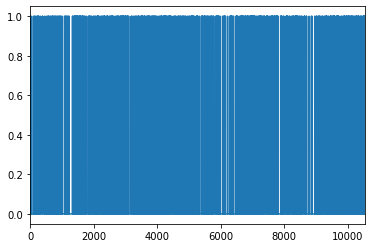

In [67]:
tur_1=pd.DataFrame(y_pred_proba[3][:,1])
#print(tur_1)
tur_1[0]=np.where(tur_1[0]>0.90,1,0)
print(tur_1[0])
tur_1[0].plot()

In [21]:
# Create Model Metrics according to test sets
XGBoost_Tune().Model_Metrics('classification')

{'max_depth': [5, 7, 8]}
model_train_name XGboost_classification_train_prediction.pckl
model_train_proba_name XGboost_classification_train_proba_prediction.pckl
model_proba_name XGboost_classification_proba_each_prediction.pckl
y_pred_train_proba [[0.8607312  0.13926883]
 [0.82694733 0.17305267]
 [0.93937725 0.06062274]
 ...
 [0.24794143 0.75205857]
 [0.7874286  0.2125714 ]
 [0.819878   0.18012203]]
y_pred_proba_list[0] [[0.947291   0.05270898]
 [0.81431794 0.18568203]
 [0.8209113  0.17908874]
 ...
 [0.8079709  0.19202909]
 [0.88429135 0.11570863]
 [0.73816764 0.26183233]]
data :  0        0.052709
1        0.185682
2        0.179089
3        0.214528
4        0.060237
5        0.183676
6        0.146230
7        0.197364
8        0.094823
9        0.166582
10       0.298501
11       0.085906
12       0.057686
13       0.373927
14       0.055008
15       0.052561
16       0.193434
17       0.166856
18       0.304804
19       0.139293
20       0.178535
21       0.038124
22       0.00868

data 2:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data :  0        0.423301
1        0.205399
2        0.212263
3        0.608164
4        0.217018
5        0.103823
6        0.506664
7        0.013238
8        0.705308
9        0.480517
10       0.163874
11       0.076407
12       0.054639
13       0.264641
14       0.271354
15       0.169702
16       0.191253
17       0.685337
18       0.111518
19       0.563334
20       0.675859
21       0.730673
22       0.264494
23       0.277716
24       0.013654
25       0.472240
26       0.060791
27       0.593206
28       0.102574
29       0.254575
30       0.027841
31       0.542055
32       0.115840
33       0.171704
34       0.205318
35       0.216755
36       0.395588
37       0.264111
38       0.072110
39       0.146824
40       0.006535
41       0.890821
42       0.590648
43       0.112034
44       0.453423
45       0.746563
46       0.209000
47       0.326402

data 2:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data :  0        0.789344
1        0.339115
2        0.574824
3        0.733314
4        0.693871
5        0.879788
6        0.875113
7        0.544936
8        0.822843
9        0.030642
10       0.236062
11       0.399000
12       0.808766
13       0.925845
14       0.900523
15       0.285015
16       0.687586
17       0.566467
18       0.905264
19       0.077038
20       0.406336
21       0.469064
22       0.579261
23       0.345213
24       0.184541
25       0.777083
26       0.078541
27       0.298262
28       0.496904
29       0.687439
30       0.761024
31       0.427615
32       0.620650
33       0.835193
34       0.694590
35       0.673259
36       0.107900
37       0.510826
38       0.416470
39       0.231859
40       0.825663
41       0.233032
42       0.029081
43       0.246303
44       0.189827
45       0.767205
46       0.410722
47       0.698606

data 2:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data :  0        0.392902
1        0.326809
2        0.282005
3        0.569174
4        0.335575
5        0.126094
6        0.057623
7        0.012115
8        0.835044
9        0.998359
10       0.016603
11       0.017562
12       0.197313
13       0.372266
14       0.266657
15       0.438138
16       0.091076
17       0.462848
18       0.253214
19       0.429631
20       0.094806
21       0.184118
22       0.058609
23       0.015295
24       0.142637
25       0.120970
26       0.015020
27       0.066048
28       0.122211
29       0.034719
30       0.732846
31       0.388940
32       0.008255
33       0.604599
34       0.258821
35       0.015780
36       0.859855
37       0.448855
38       0.056216
39       0.012746
40       0.037516
41       0.022798
42       0.066602
43       0.151069
44       0.012534
45       0.243153
46       0.004151
47       0.268752

data 2:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
data :  0        0.525646
1        0.923174
2        0.505977
3        0.472963
4        0.081042
5        0.247232
6        0.233573
7        0.306641
8        0.570201
9        0.226960
10       0.882277
11       0.612676
12       0.235734
13       0.076911
14       0.772676
15       0.230803
16       0.504285
17       0.127889
18       0.871666
19       0.676191
20       0.918249
21       0.897129
22       0.998178
23       0.043407
24       0.246281
25       0.100710
26       0.398794
27       0.121405
28       0.888983
29       0.896742
30       0.125295
31       0.164300
32       0.413156
33       0.156658
34       0.228177
35       0.037721
36       0.137347
37       0.101042
38       0.540642
39       0.858935
40       0.031239
41       0.178702
42       0.048330
43       0.365617
44       0.786956
45       0.505535
46       0.322636
47       0.904746

data 2:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


ValueError: Found input variables with inconsistent numbers of samples: [10541, 10]

In [ ]:
# Create Model Metrics according to test sets
XGBoost_Tune().Model_Metrics('classification')
LightGBM_Tune().Model_Metrics('classification')
CatBoost_Tune().Model_Metrics('classification')
Random_Forest_Tune().Model_Metrics('classification')
#SVC_Tune().Model_Metrics('classification')

In [ ]:
# Plot Results of Grid Search
XGBoost_Tune().grid_plot()
LightGBM_Tune().grid_plot()
CatBoost_Tune().grid_plot()
Random_Forest_Tune().grid_plot()
SVC_Tune().grid_plot()

In [ ]:
# Plot Results of Grid Search
XGBoost_Tune().grid_plot()